# Lab1 (5IR - 2024): Human Activity Recognition (HAR) - Supervised learning

**Group name:**  A1

**Names:** MOULIN  JEAN-BAPTISTE

**First names:** Romain Aude



In this project, we will try to predict 8 different human activities: 

1-Recumbent, 2-Sitting, 3-Standing, 4-Walking, 5-Biking, 6-Nordic Walking, 7-Cleaning_Aspirator or 8-Repassing 

using different sensors (accelerometer, gyroscope, magnetometer or temperature) placed at different points on the body (hand, torso and ankle).


For the accelerometer, gyroscope and magnetometer sensors, measurements in $ms^{-2}$, $rad/s$ and $\mu T$ respectively are taken on the 3-axes at a sampling rate of 100Hz. Each measurement is labeled.

<img src="HARDataset.JPG" width="800" height="600" >

For each sensor and position, a matrix of the measurements collected is provided, along with the activity label (i.e. the ground truth). 

This tutorial is divided into 3 parts:
- Part I: Implementing DTW to create a k-NN recognition system;
- Part II: Dimension reduction using PCA and classification using neural networks;
- Part III: (Bonus) Dimension reduction using k-medoids for DTW + k-NN.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns
from sklearn import neighbors

# Loading training and test data

In [2]:
def smooth_signal(X, k):
    for i in range(len(X)):
        Xi = X[i]
        downsample=math.ceil(len(Xi)/k)
        for j in range(downsample):
            Xj = Xi[j*k:min((j+1)*k, len(Xi)),:]
            X[i,j] = np.mean(Xj, axis=0)
    X = X[:,:downsample,:]
    return X

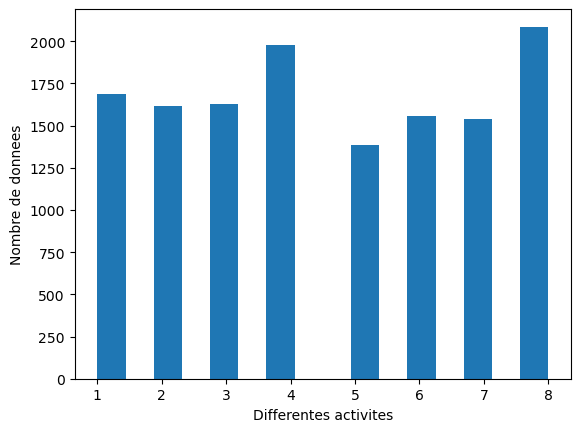

In [3]:
# Data loading

# Sensors part (Accelerometer, Gyroscope and Magnetometer) placed on the Hand 
# (do the same for the 2 other sensor positions: torso and ankle)
fh1=np.load('DataHandAcc.npz')
DataHandAcc=fh1['DataHandAcc']
DataHandAcc= smooth_signal(DataHandAcc,5)
fh2=np.load('DataHandGyro.npz')
DataHandGyro=fh2['DataHandGyro']
DataHandGyro= smooth_signal(DataHandGyro,5)
fh3=np.load('DataHandMagneto.npz')
DataHandMagneto=fh3['DataHandMagneto']
DataHandMagneto= smooth_signal(DataHandMagneto,5)
# TODO
# ADD HERE the loading of the other sensors
ft1=np.load('DataChestAcc.npz')
DataTorsoAcc=ft1['DataChestAcc']
DataTorsoAcc= smooth_signal(DataTorsoAcc,5)
ft2=np.load('DataChestGyro.npz')
DataTorsoGyro=ft2['DataChestGyro']
DataTorsoGyro= smooth_signal(DataTorsoGyro,5)
ft3=np.load('DataChestMagneto.npz')
DataTorsoMagneto=ft3['DataChestMagneto']
DataTorsoMagneto= smooth_signal(DataTorsoMagneto,5)

fa1=np.load('DataAnkleAcc.npz')
DataAnkleAcc=fa1['DataAnkleAcc']
DataAnkleAcc= smooth_signal(DataAnkleAcc,5)
fa2=np.load('DataAnkleGyro.npz')
DataAnkleGyro=fa2['DataAnkleGyro']
DataAnkleGyro= smooth_signal(DataAnkleGyro,5)
fa3=np.load('DataAnkleMagneto.npz')
DataAnkleMagneto=fa3['DataAnkleMagneto']
DataAnkleMagneto= smooth_signal(DataAnkleMagneto,5)

# Loading the ground truth: labels
fl=np.load('labels.npz')
labels=fl['labels']

# Repartition of data by class
plt.hist(labels,bins=16)
plt.xlabel('Differentes activites')
plt.ylabel('Nombre de donnees')
plt.show()



In [4]:
# Separation of data into training and test databases
from sklearn.model_selection import train_test_split

listeData=[*range(labels.shape[0])] 
Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(listeData,labels, test_size=0.20, random_state=42)



# Part I-a: Implementing the dynamic programming algorithm 

1. Write a function in DTW python that implements the calculation. Implement it such that
- the local distance used is a parameter which is a callable function with 2 inputs and 1 output: e.g. euclidian distance(a, b)
- local distances can be computed with any type of input local data: e.g. (a,b)=('A','T'), (a,b)=(12,22), (a,b)=( (1,2,3), (4,5,6) ).

In [5]:

def dtw(local_distance, datas_a:list, datas_b:list, contraintes:list, test=False): # contraintes : liste des contraintes. globale en dernier 
                                                                # si test à vrai, on retourne la matrice de poids 
    n=len(datas_a)
    m=len(datas_b)
    w0,w1,w2,global_cons=contraintes
    tab_dtw=np.zeros((n+1,m+1))
    tab_dtw[0,0]=0
    for j in range(1, m+1):
        tab_dtw[0,j] = np.inf
    for i in range(1, n+1): 
        tab_dtw[i,0] = np.inf
        for j in range(1, m+1):
            if abs(i-j) >= global_cons:
                tab_dtw[i,j]=np.inf
                continue
            local_d=local_distance(datas_a[i-1],datas_b[j-1])
            x=tab_dtw[i-1,j]+w0*local_d
            y=tab_dtw[i-1,j-1]+w1*local_d
            z=tab_dtw[i,j-1]+w2*local_d
            tab_dtw[i,j]=min(x,y,z)
    alignement_score=tab_dtw[n,m]/(n+m)
    if test:
        return(alignement_score,tab_dtw)
    else:
        return alignement_score

In [6]:
#Test sur les séquences d'ADN 

def local_dist(a,b):
    return(0 if a==b else 1)

data_b = "ATGGTACGTC"
data_a = "AAGTAGGC"

contrainte = [1,1,1,4]

score, matrix = dtw(local_dist,data_a,data_b,contrainte,test=True)
print(score)
print(matrix)

0.16666666666666666
[[ 0. inf inf inf inf inf inf inf inf inf inf]
 [inf  0.  1.  2.  3. inf inf inf inf inf inf]
 [inf  0.  1.  2.  3.  4. inf inf inf inf inf]
 [inf  1.  1.  1.  1.  2.  3. inf inf inf inf]
 [inf  2.  1.  2.  2.  1.  2.  3. inf inf inf]
 [inf inf  2.  2.  3.  2.  1.  2.  3. inf inf]
 [inf inf inf  2.  2.  3.  2.  2.  2.  3. inf]
 [inf inf inf inf  2.  3.  3.  3.  2.  3.  4.]
 [inf inf inf inf inf  3.  4.  3.  3.  3.  3.]]


In [7]:
#Test donné en TP (vecteur 1D)

def local_dist(a,b):
    return(abs(a-b))

data_a=[5,1]
data_b=[4,6,1]

contrainte = [1,1,1,2]

score, matrix = dtw(local_dist,data_a,data_b,contrainte,test=True)
print(score)
print(matrix)

0.4
[[ 0. inf inf inf]
 [inf  1.  2. inf]
 [inf  4.  6.  2.]]


In [8]:
#Test donné en TP (vecteur 2D)

def local_dist(a,b):
    res=0
    for i in range(len(a)):
        res+=abs(a[i]-b[i])
    return res

data_a=[(1,3),(2,1)]
data_b=[(1,1),(2,2)]

contrainte = [1,1,1,4]

score, matrix = dtw(local_dist,data_a,data_b,contrainte,test=True)
print(score)
print(matrix)

0.75
[[ 0. inf inf]
 [inf  2.  4.]
 [inf  3.  3.]]


2. Test your methods on the examples given in class.

# Part I-b: DTW human activity recognition system

For each test time profile :

a) For each class, compute the DTW score between the test temporal profile and the temporal profiles of the class. Test with data from only one sensor then include them all if possible.

b) Determine the class membership by k-nearest neighbors

**Information:**
We use the library sklearn.neighbors to execute an example of this classification algorithm.

The algorithm k-NN is implemented in a package called **neighbors**.
Here are the main commands:
- The line **clf = neighbors.KNeighborsClassifier(n_neighbors)** creates an object of type classifier based on the n_neighbors closest neighbors,
- The instruction clf.fit(X, y) uses the data to define the classifier (training),
- The command **clf.predict()** is used to classify the new examples,
- The command **clf.predict_proba()** allows to estimate the probability of the proposed classification,
- The command **clf.score(xtest, ytest)** computes the global score of the classifier for a given dataset.

<img src="https://miro.medium.com/v2/resize:fit:488/1*9h-WczF6csbeut5vsvjSUA.gif" alt="k-NN example" />

KNeighborsClassifier takes as argument *metrics* which can be:
- a string with the distance name: default='minkowski'
- a callable function taking as input 2 arrays representing 1D vectors and returning one value indicating the distance between those vectors. **Use this option with the DTW function you implemented.**

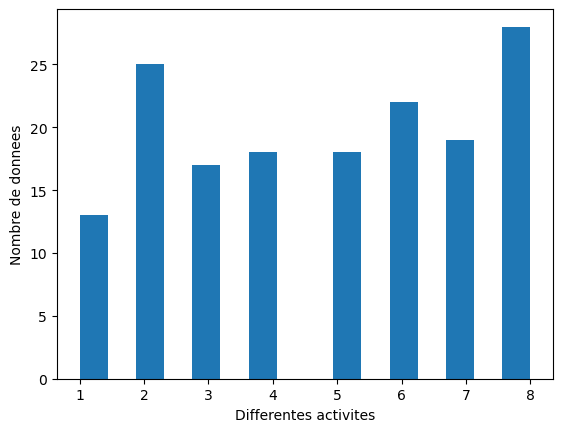

entrainement terminé
0.575
fini!


In [9]:


k=5
size=200

def local_dist(a,b):
    return(abs(a-b))

def dtw_new(data_a,data_b):
    return(dtw(local_dist,data_a,data_b,[1,1,1,5]))


clf=neighbors.KNeighborsClassifier(n_neighbors=k,metric=dtw_new)

# test sur les données de l'accéléromètre de la cheville

sample_indices=np.random.randint(len(DataAnkleAcc),size=size)
sample_data = DataAnkleAcc[sample_indices]
sample_labels = labels[sample_indices]

Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(sample_data,sample_labels, test_size=0.20, random_state=42)

# Repartition of data by class
plt.hist(y_train,bins=16)
plt.xlabel('Differentes activites')
plt.ylabel('Nombre de donnees')
plt.show()

clf.fit(Liste_Base_train[:,:,0],y_train) # première dimension (datas en 3D)
print('entrainement terminé')
score=clf.score(Liste_Base_test[:,:,0],y_test)
print("score: "+ str(score))
print('fini!')

## **Evaluation:** 
From the prediction on the test set obtained after DTW, compute the confusion matrix that counts the number of well-ranked and poorly-ranked data.

Analyse the results (accuracy, execution time, ...)

k = 5, size = 200


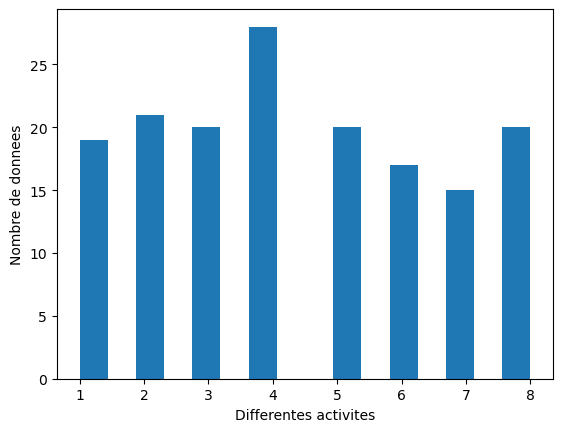

entrainement terminé
Matrice de confusion par DTW :
[[2 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0]
 [0 7 3 0 0 0 0 1]
 [0 0 0 9 0 1 0 0]
 [0 0 1 0 0 0 1 0]
 [0 0 0 3 0 1 0 0]
 [0 0 0 0 0 0 0 2]
 [0 2 2 0 0 0 0 2]]
Score de classification : 0.475


In [12]:

# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

k=5
size=200

print("k = {}, size = {}".format(k,size))

clf=neighbors.KNeighborsClassifier(n_neighbors=k,metric=dtw_new)

# test sur les données de l'accéléromètre de la cheville
sample_indices=np.random.randint(len(DataAnkleAcc),size=size)
sample_data = DataAnkleAcc[sample_indices]
sample_labels = labels[sample_indices]

Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(sample_data,sample_labels, test_size=0.20, random_state=42)

# Repartition of data by class
plt.hist(y_train,bins=16)
plt.xlabel('Differentes activites')
plt.ylabel('Nombre de donnees')
plt.show()


clf.fit(Liste_Base_train[:,:,0],y_train) # première dimension (datas en 3D)
print('entrainement terminé')

predictions=clf.predict(Liste_Base_test[:,:,0]) # juste la première dimension 
matrice=confusion_matrix(y_test,predictions)

print('Matrice de confusion par DTW :')
print(matrice)

score_5_200=accuracy_score(y_test,predictions)
# Score de performance
print('Score de classification : '+str(score_5_200))
#print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

k = 5, size = 500


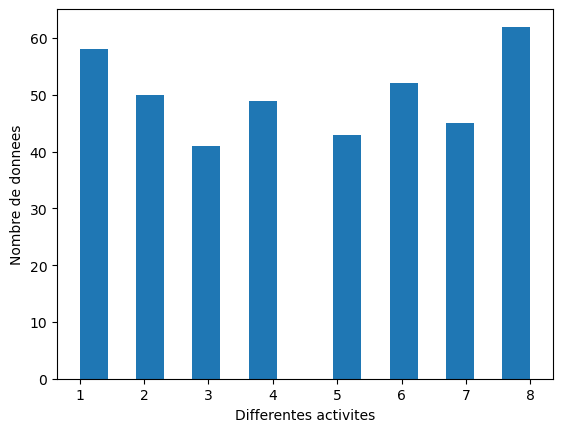

entrainement terminé
Matrice de confusion par DTW :
[[ 6  1  1  0  0  0  0  0]
 [ 1  5  1  0  0  0  0  0]
 [ 0  9  5  0  0  0  0  1]
 [ 0  1  0 12  0  3  0  1]
 [ 0  0  2  0  6  0  0  0]
 [ 0  0  1  3  0 13  0  2]
 [ 0  0  3  0  0  0  4  5]
 [ 0  4  4  0  0  0  0  6]]
Score de classification : 0.57


In [13]:
k=5
size=500

print("k = {}, size = {}".format(k,size))

clf=neighbors.KNeighborsClassifier(n_neighbors=k,metric=dtw_new)

# test sur les données de l'accéléromètre de la cheville
sample_indices=np.random.randint(len(DataAnkleAcc),size=size)
sample_data = DataAnkleAcc[sample_indices]
sample_labels = labels[sample_indices]

Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(sample_data,sample_labels, test_size=0.20, random_state=42)

# Repartition of data by class
plt.hist(y_train,bins=16)
plt.xlabel('Differentes activites')
plt.ylabel('Nombre de donnees')
plt.show()


clf.fit(Liste_Base_train[:,:,0],y_train) # première dimension (datas en 3D)
print('entrainement terminé')

predictions=clf.predict(Liste_Base_test[:,:,0]) # juste la première dimension 
matrice=confusion_matrix(y_test,predictions)

print('Matrice de confusion par DTW :')
print(matrice)

score_5_500=accuracy_score(y_test,predictions)
# Score de performance
print('Score de classification : '+str(score_5_500))
#print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

k = 10, size = 200


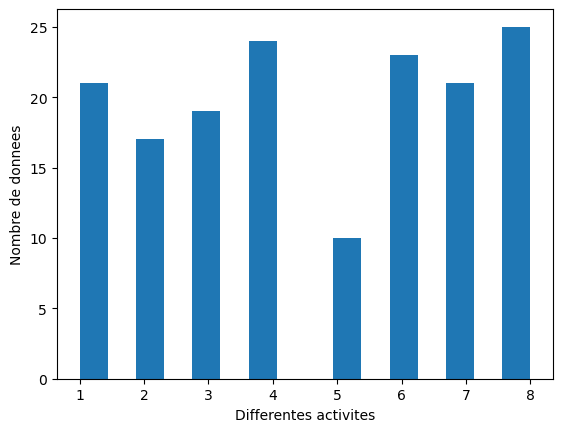

entrainement terminé
Matrice de confusion par DTW :
[[6 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0]
 [0 1 2 0 0 0 0 2]
 [0 0 0 6 0 1 1 0]
 [0 0 0 0 3 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 3]
 [0 3 0 0 0 0 0 4]]
Score de classification : 0.575


In [18]:
k=10
size=200

print("k = {}, size = {}".format(k,size))

clf=neighbors.KNeighborsClassifier(n_neighbors=k,metric=dtw_new)

# test sur les données de l'accéléromètre de la cheville
sample_indices=np.random.randint(len(DataAnkleAcc),size=size)
sample_data = DataAnkleAcc[sample_indices]
sample_labels = labels[sample_indices]

Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(sample_data,sample_labels, test_size=0.20, random_state=42)

# Repartition of data by class
plt.hist(y_train,bins=16)
plt.xlabel('Differentes activites')
plt.ylabel('Nombre de donnees')
plt.show()


clf.fit(Liste_Base_train[:,:,0],y_train) # première dimension (datas en 3D)
print('entrainement terminé')

predictions=clf.predict(Liste_Base_test[:,:,0]) # juste la première dimension 
matrice=confusion_matrix(y_test,predictions)

print('Matrice de confusion par DTW :')
print(matrice)

score_10_200=accuracy_score(y_test,predictions)
# Score de performance
print('Score de classification : '+str(score_10_200))
#print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

k = 10, size = 500


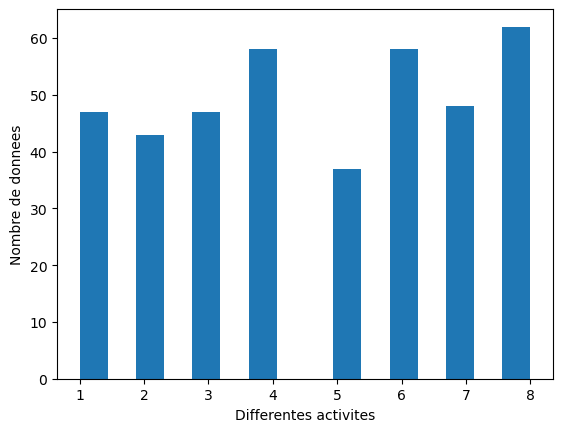

entrainement terminé
Matrice de confusion par DTW :
[[ 7  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  2]
 [ 0  9  4  0  0  0  0  4]
 [ 0  0  0 16  0  3  0  0]
 [ 0  0  0  0  4  0  2  0]
 [ 0  0  0  6  0  9  0  0]
 [ 0  1  1  0  0  0  6  4]
 [ 0  5 11  0  0  0  0  3]]
Score de classification : 0.52


In [19]:
k=10
size=500

print("k = {}, size = {}".format(k,size))

clf=neighbors.KNeighborsClassifier(n_neighbors=k,metric=dtw_new)

# test sur les données de l'accéléromètre de la cheville
sample_indices=np.random.randint(len(DataAnkleAcc),size=size)
sample_data = DataAnkleAcc[sample_indices]
sample_labels = labels[sample_indices]

Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(sample_data,sample_labels, test_size=0.20, random_state=42)

# Repartition of data by class
plt.hist(y_train,bins=16)
plt.xlabel('Differentes activites')
plt.ylabel('Nombre de donnees')
plt.show()


clf.fit(Liste_Base_train[:,:,0],y_train) # première dimension (datas en 3D)
print('entrainement terminé')

predictions=clf.predict(Liste_Base_test[:,:,0]) # juste la première dimension 
matrice=confusion_matrix(y_test,predictions)

print('Matrice de confusion par DTW :')
print(matrice)

score_10_500=accuracy_score(y_test,predictions)
# Score de performance
print('Score de classification : '+str(score_10_500))
#print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

k = 15, size = 200


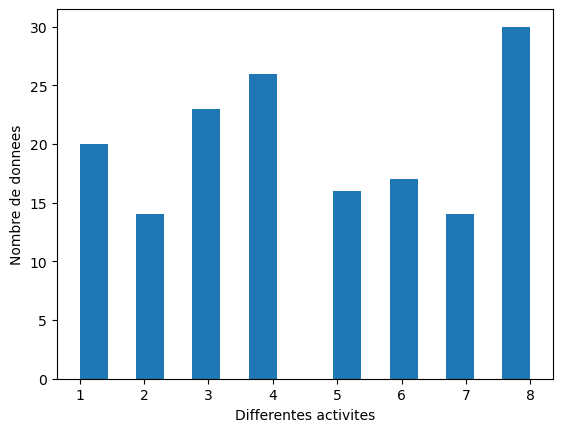

entrainement terminé
Matrice de confusion par DTW :
[[3 0 0 0 0 0 0 1]
 [1 1 2 0 0 0 0 0]
 [0 2 4 0 0 0 0 2]
 [0 0 0 5 0 3 0 0]
 [0 0 0 0 2 0 3 0]
 [0 0 0 4 0 1 0 0]
 [0 0 0 0 0 0 0 2]
 [0 1 3 0 0 0 0 0]]
Score de classification : 0.4


In [20]:
k=15
size=200

print("k = {}, size = {}".format(k,size))

clf=neighbors.KNeighborsClassifier(n_neighbors=k,metric=dtw_new)

# test sur les données de l'accéléromètre de la cheville
sample_indices=np.random.randint(len(DataAnkleAcc),size=size)
sample_data = DataAnkleAcc[sample_indices]
sample_labels = labels[sample_indices]

Liste_Base_train, Liste_Base_test, y_train, y_test = train_test_split(sample_data,sample_labels, test_size=0.20, random_state=42)

# Repartition of data by class
plt.hist(y_train,bins=16)
plt.xlabel('Differentes activites')
plt.ylabel('Nombre de donnees')
plt.show()


clf.fit(Liste_Base_train[:,:,0],y_train) # première dimension (datas en 3D)
print('entrainement terminé')

predictions=clf.predict(Liste_Base_test[:,:,0]) # juste la première dimension 
matrice=confusion_matrix(y_test,predictions)

print('Matrice de confusion par DTW :')
print(matrice)

score_15_200=accuracy_score(y_test,predictions)
# Score de performance
print('Score de classification : '+str(score_15_200))
#print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

In [24]:
recap=[[5,200,score_5_200,"1min6"],[5,500,score_5_500,"6min48"],[10,200,score_10_200,"1min10"],[10,500,score_10_500,"6min28"],[15,200,score_15_200,"1min2"]]

nb=0
for model in recap:
    print("modèle {}".format(nb))
    nb+=1
    print("k: {}, nombre d'échantillons: {}, score: {}, temps de compilation: {}\n".format(model[0],model[1],model[2],model[3]))

modèle 0
k: 5, nombre d'échantillons: 200, score: 0.475, temps de compilation: 1min6

modèle 1
k: 5, nombre d'échantillons: 500, score: 0.57, temps de compilation: 6min48

modèle 2
k: 10, nombre d'échantillons: 200, score: 0.575, temps de compilation: 1min10

modèle 3
k: 10, nombre d'échantillons: 500, score: 0.52, temps de compilation: 6min28

modèle 4
k: 15, nombre d'échantillons: 200, score: 0.4, temps de compilation: 1min2



## Interprétation 

Nos modèles donnent de pauvres résultats, ce qui n'est pas étonnant vu que l'on ne considère qu'une seule dimension d'un seul capteur. Considérant cela, tourner autour de 50% de précision peut même être considéré comme relativement correct. De plus, on peut varier le nombre d'échantillons et le k pour améliorer la précision. La meilleure valeur de k dans notre exemple est autour de 10. Quant à la taille de l'échantillon, il est efficace de l'augmenter pour un petit k, mais cela perd en intérêt quand k augmente. De plus, les temps de compilation sont nettement plus longs quand on considère plus d'échantillons, ce qui est à considérer. 

Lors de tests plus exhaustifs, on pourrait tenter de trouver la taille d'échantillon optimal pour un k fixe.

Enfin, avec plus de capacité de calcul et de temps, nous aurions pu exécuter cet algorithme sur l'intégralité du dataset et avec davantage de capteurs, ce qui aurait probablement donné de bien meilleurs résultats. 

# BONUS #
# Part II: Comparison of dynamic programming with a neural network classification method after PCA dimension reduction

In this section, we will compare the results of DTW with those of a data classification method: neural networks (Multi-Layer Perceptron).

We'll be using the functions for calculating PCA and MLPClassifier via the *scikit-learn* python library.

In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

### PCA pre-processing


To test another classification method, 


1. From the Data_App data in the training database, and using the *PCA* function in the *scikit-learn* library, calculate the $p$ principal axes of the PCA by
extracting the $p$ eigenvectors, denoted $X_1$, $X_2$,..., $X_p$, associated with the $p$ largest eigenvalues of the variance-covariance matrix
variance-covariance matrix $\Sigma_{App}$. These eigenvectors will form the new database.


2. Project the data from the training and test database into this new database by multiplying each vector
vector by the base $P = [X_1X_2...X_p]$.


*Note:* you can also implement PCA by extracting the
extracting the $p$ eigenvectors, denoted $X_1$, $X_2$,... $X_p$, associated with the $p$ largest eigenvalues of the
variance-covariance matrix $\Sigma_{App}$ (by the functions *np.cov* and *np.linalg.eig*). These eigenvectors will form the new frame P. Then project the data from the training and test frames into this new frame by multiplying each vector by the frame $P = [X_1X_2..X_p]$.

In [ ]:
# TODO

### Classification using neural networks
1. Classification using neural networks
2. Evaluate results using confusion matrix, loss function, etc.
3. Test different architectures and solvers: train on the training set and compute score on the test set

Analyse the results (accuracy, execution time, ...)

We will use the library **sklearn.model_selection** to develop ANN of type Multi Layer Perceptron (MLP). We use the class: MLPClassifier.

<img src="https://rasbt.github.io/mlxtend/user_guide/classifier/NeuralNetMLP_files/neuralnet_mlp_1.png" alt="MLP example" />

This model optimizes the cross entropy function (loss function) and a gradient based method.
The main parameters of this class are:
- **hidden_layer_sizes** is a tuple that specifies the number of neurons in each hidden layer; from the entrance to the exit. For example, a unique hidden layer of 55 neurons, hidden_layer_sizes = (55); for three hidden layers of size respectively 50, 12 and 100 neurons, hidden_layer_sizes = (50, 12, 100).
- **activation** defines the activation function for hidden layers: {"identity", "logistic", "tanh", "relu"}, default "relu"
    - ‘identity’, no-op activation, linear bottleneck, returns f(x) = x
    - ‘logistic’, logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
    - ‘tanh’, hyperbolic tan function, returns f(x) = tanh(x).
    - ‘relu’, rectified linear unit function, returns f(x) = max(0, x)
- **solver** {"lbfgs", "sgd", "adam"} specifies the algorithm used to minimize the output loss function. "Adam" is implemented by default for large databases. For small databases, ‘lbfgs’ may converge better.
- **alpha** default value=0.0001: is the magnitude of the L2 regularization. It is a method of regulation (to prevent overfitting) whose purpose is to penalize heavy weights. We add the penalty to the cost function.
- **max iter**, default =200, indicates the max number of iterations of the solver.
- **tol** , default 1e-4: is a tolerance factor that allows the solver to be stopped early when there is no improvement.
- **Verbose** bool, default=’False’ : change to “True” to print progress messages to stdout.
- **warm_start** bool, default=’False’: When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution.
- **early_stopping** bool, default=’False’: Whether to use early stopping to terminate training when validation score is not improving (prevent overfitting). If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. If early stopping is False, then the training stops when the training loss does not improve by more than tol for n_iter_no_change consecutive passes over the training set. Only effective when solver=’sgd’ or ‘adam’.
- **validation_fraction** float, default=0.1 The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True.
- **n_iter_no_change** int, default=10: Maximum number of epochs to not meet tol improvement. Only effective when solver=’sgd’ or ‘adam’.

The main commands are:
- mlp = MLPClassifier(hidden_layer_sizes=(20, 20, 10,), max_iter=300, activation='relu', solver='adam', random_state=42)
- mlp.fit(xtrain, ytrain)
- ypred = mlp.predict(xtest)

Accuracy of the model can eventually be computed using the library **sklearn.metrics** and the commands:
- Score: accuracy_score(y_test, y_pred)
- Report: classification_report(y_test, y_pred))

The usual sklearn learning and testing functions are as follows: (**fit**, **predict**, **score**).

In [5]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# TODO

# Partie III (Bonus): reduction of the training basis by k-medoids to optimize classification by k-NN with DTW as similarity measure

For each class of activity
a) Compute medoids using *k-medoids* from the scikit-learn library with DTW as similarity measure.

b) Vary the parameter k and observe the evolution of the *silhouette score*: select the best by the elbow method

c) Replace the samples with the medoids found from the best k parameter

Finally, run the k-NN algorithm for classification and evaluate as before: the only change is that your training set has been replaced

**Information:**
We use the KMedoids (kM) method: this is an unsupervised approach which clusters your data in k groups such that a similarity measure is:
- minimized inside each group
- maximized inside between groups
We obtain for each group a centroid (or medoid) which is at the center and thus represents best the group (w.r.t. the similarity measure).

The algorithm kM is implemented in a package called **sklearn_extra.cluster**.
Here are the main commands:
- The line **clf = sklearn_extra.cluster.KMedoids(n_clusters=k)** creates an object of type classifier based on the n_neighbors closest neighbors,
- The instruction clf.fit(X, y) uses the data to define the classifier (training),
- The command **clf.predict()** is used to classify the new examples,
- The command **clf.predict_proba()** allows to estimate the probability of the proposed classification,
- The command **clf.score(xtest, ytest)** computes the global score of the classifier for a given dataset.

<img src="https://scikit-learn-extra.readthedocs.io/en/stable/_images/sphx_glr_plot_kmedoids_digits_001.png" alt="k-Medoids example" />

KMedoids takes as argument *metrics* which can be your DTW function.

The silhouette score is then a measure of the quality of your clustering, and is implemented as the function silhouette_score in a package called **sklearn.metrics**.

In [ ]:
# TODO (Bonus)